In [116]:
import numpy as np

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def draw_card():
    choice=np.random.randint(0,len(deck))
    return deck[choice]

#choose two card at the begining
def draw_hand():
    return[draw_card(),draw_card()]

#define whether player or dealer has a usable ace
def usable_ace(hand):
    if (1 in hand) and sum(hand)<=11:
        return True
    else:
        return False

#define the total sum of hand
def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand)+10
    else:
        return sum(hand)
    
    
#whether bust
def is_bust(hand):
    return sum_hand(hand)>21

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

#whether natural
def is_natural(hand):
    return hand==[1,10]

def cmp(a,b):
    return int(a>b)-int(a<b)



class Blackjack(object):
    def __init__(self,natural=False):
        self.natural = natural
        self.nA=2
        self.player=None
        self.dealer=None
        


    def observation(self):
        return (sum_hand(self.player),self.dealer[0],usable_ace(self.player))

    def _reset(self):
        self.player=draw_hand()
        self.dealer=draw_hand()
        while sum_hand(self.player)<12:
            self.player.append(draw_card())
        return self.observation()

    def _step(self,action):
        go_on=True
        if action:
            self.player.append(draw_card())
            if is_bust(self.player):
                self.player=[0]
                reward=-1
                go_on=False
            else:
                go_on=True
                reward=0
        else:
            while sum_hand(self.dealer)<17:
                self.dealer.append(draw_card())
            if sum_hand(self.player)==21:
                reward=1
                
            else:
                if is_bust(self.dealer):
                    reward=1
                    
                else:
                    reward=cmp(sum_hand(self.player),sum_hand(self.dealer))
            go_on=False
                
        return self.observation(),reward,go_on


In [131]:
from collections import defaultdict
import sys
def sample_policy(nA):
    A=np.ones(nA,dtype=np.float32)/nA
    return A

def Off_Policy_Control(episode_nums,decay_rate=1):
    env=Blackjack()
    
    Q=defaultdict(lambda:np.zeros(env.nA))
    target_policy=defaultdict(float)
    record=defaultdict(float)
    
    for i_episode in range(episode_nums):
        episode=[]
        prob_b=[]
        env._reset()
        state=env.observation()
        if i_episode % 1000000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, episode_nums))
            sys.stdout.flush()
        for i in range(30):
            prob=sample_policy(env.nA)
            action=np.random.choice(np.arange(env.nA),p=prob)
            next_state,reward,go_on=env._step(action)
            episode.append((state,reward,action))
            prob_b.append(prob[action])
            if go_on:
                state=next_state
            else:
                break
        
        G=0.0
        W=1.0
        prob_b=prob_b[::-1]
        
        for idx,eps in enumerate(episode[::-1]):
            state,reward,action=eps
            pair=(state,action)
            record[pair]+=W
            G=decay_rate*G+reward
            Q[state][action]+=W/record[pair]*(G-Q[state][action])
            target_policy[state]=np.argmax(Q[state])
            if action!=target_policy[state]:
                break
            W=W/prob_b[idx]
    return Q,target_policy
            
            


In [132]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111,projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

def printPolicy(V):
        min_x = min(k[0] for k in V.keys())
        max_x = max(k[0] for k in V.keys())
        min_y = min(k[1] for k in V.keys())
        max_y = max(k[1] for k in V.keys())

        x_range = np.arange(min_x, max_x + 1)
        y_range = np.arange(min_y, max_y + 1)
        X, Y = np.meshgrid(x_range, y_range)
        
        # Find value for all (x, y) coordinates
        Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
        Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
        df1=pd.DataFrame(Z_ace,index=y_range,columns=x_range)
        df2=pd.DataFrame(Z_noace,index=y_range,columns=x_range)
        plt.figure()
        ax = sns.heatmap(df2,vmax=1,vmin=-1)
        ax.set_title('Best Policy with no ace ')
        ax.set_ylabel('dealer')
        ax.set_xlabel('player')
        
        plt.figure()
        ax = sns.heatmap(df1,vmax=1,vmin=-1)
        ax.set_title('Best Policy with ace')
        ax.set_ylabel('dealer')
        ax.set_xlabel('player')

Episode 0/5000000.
Episode 1000000/5000000.
Episode 2000000/5000000.
Episode 3000000/5000000.
Episode 4000000/5000000.


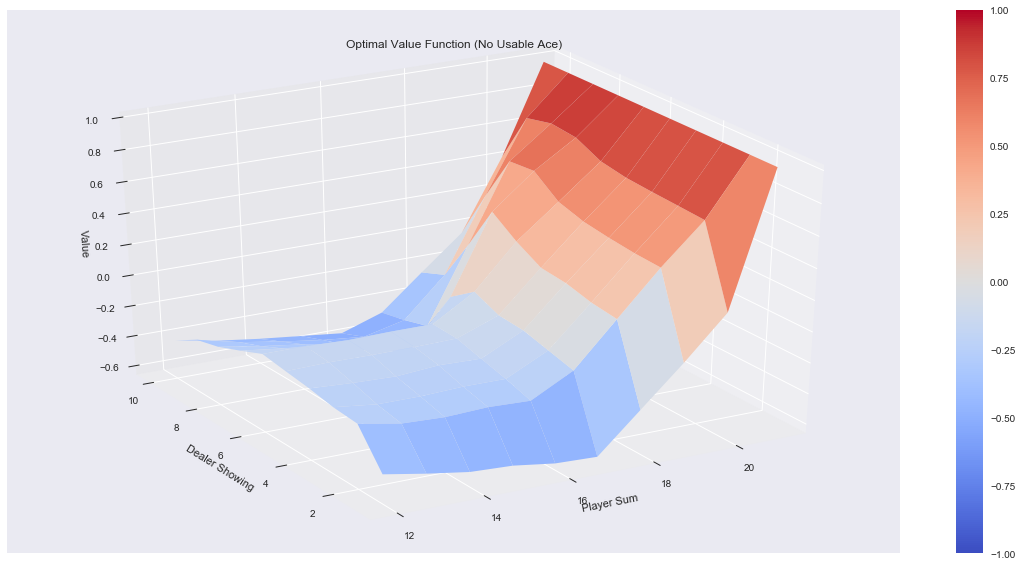

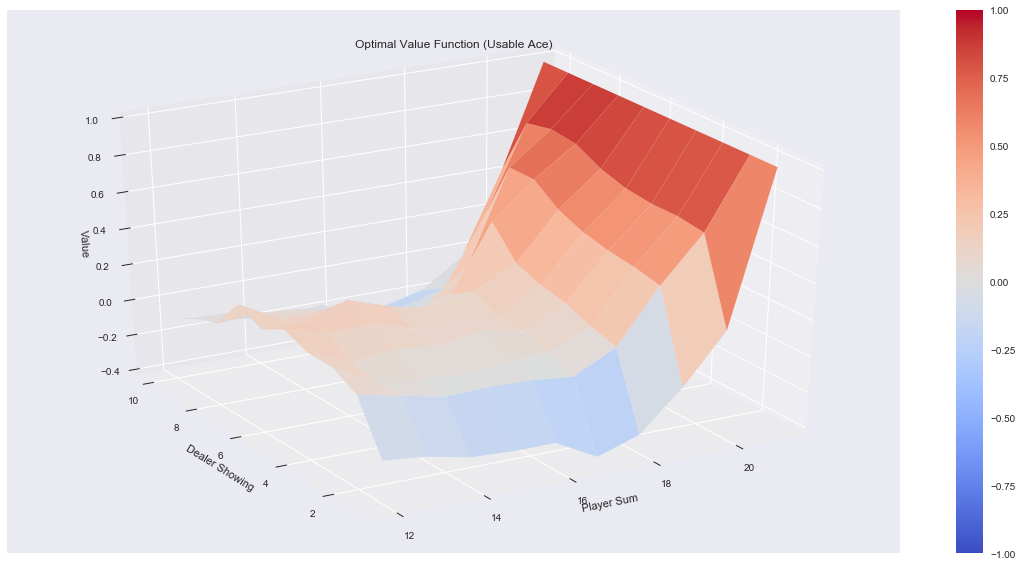

In [133]:
env=Blackjack()
Q,Best_policy=Off_Policy_Control(5000000)
V=defaultdict(float)
for state, actions in Q.items():
    action_value=np.max(actions)
    V[state]=action_value
plot_value_function(V, title="Optimal Value Function")


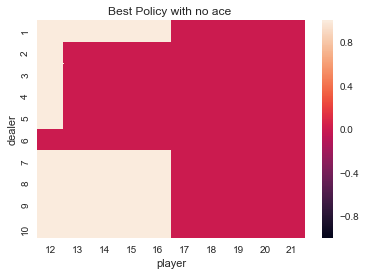

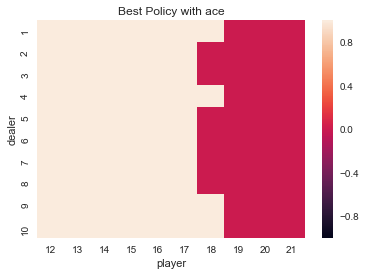

In [134]:
printPolicy(Best_policy)

In [135]:
episilon=0.1
from collections import defaultdict
def best_policy(Q,observation,nA):
    A=np.ones(nA,dtype=np.float32)*episilon/nA
    best_action=np.argmax(Q[observation])
    A[best_action]+=1-episilon
    return A

def On_Policy_Evaluation(episode_nums,decay_rate=1):
    env=Blackjack()
    
    Q=defaultdict(lambda:np.zeros(2))
    return_sum=defaultdict(float)
    return_count=defaultdict(float)
    
    for i_episode in range(episode_nums):
        episode=[]
        env._reset()
        state=env.observation()
        if i_episode % 100000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, episode_nums))
            sys.stdout.flush()
        for i in range(30):
            prob=best_policy(Q,state,env.nA)
            action=np.random.choice(np.arange(env.nA),p=prob)
            next_state,reward,go_on=env._step(action)
            episode.append((state,action,reward))
            if go_on:
                state=next_state
            else:
                break
       
        seperate_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state,action in seperate_episode:
            for idx , eps in enumerate(episode):
                if eps[0]==state and eps[1]==action:
                    first_visit_idx=idx
                    break
            pair=(state,action)
            G=sum(eps1[2]*(decay_rate**i) for i ,eps1 in enumerate(episode[first_visit_idx:]))
            return_sum[pair]+=G
            return_count[pair]+=1
            Q[state][action]=return_sum[pair]*1.0/return_count[pair]
    return Q

Episode 0/5000000.
Episode 100000/5000000.
Episode 200000/5000000.
Episode 300000/5000000.
Episode 400000/5000000.
Episode 500000/5000000.
Episode 600000/5000000.
Episode 700000/5000000.
Episode 800000/5000000.
Episode 900000/5000000.
Episode 1000000/5000000.
Episode 1100000/5000000.
Episode 1200000/5000000.
Episode 1300000/5000000.
Episode 1400000/5000000.
Episode 1500000/5000000.
Episode 1600000/5000000.
Episode 1700000/5000000.
Episode 1800000/5000000.
Episode 1900000/5000000.
Episode 2000000/5000000.
Episode 2100000/5000000.
Episode 2200000/5000000.
Episode 2300000/5000000.
Episode 2400000/5000000.
Episode 2500000/5000000.
Episode 2600000/5000000.
Episode 2700000/5000000.
Episode 2800000/5000000.
Episode 2900000/5000000.
Episode 3000000/5000000.
Episode 3100000/5000000.
Episode 3200000/5000000.
Episode 3300000/5000000.
Episode 3400000/5000000.
Episode 3500000/5000000.
Episode 3600000/5000000.
Episode 3700000/5000000.
Episode 3800000/5000000.
Episode 3900000/5000000.
Episode 4000000

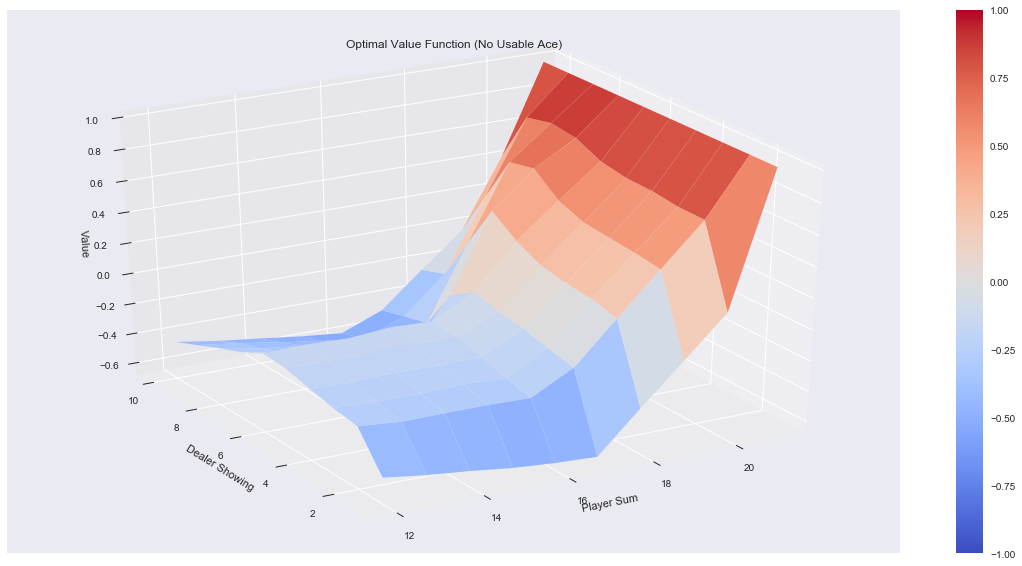

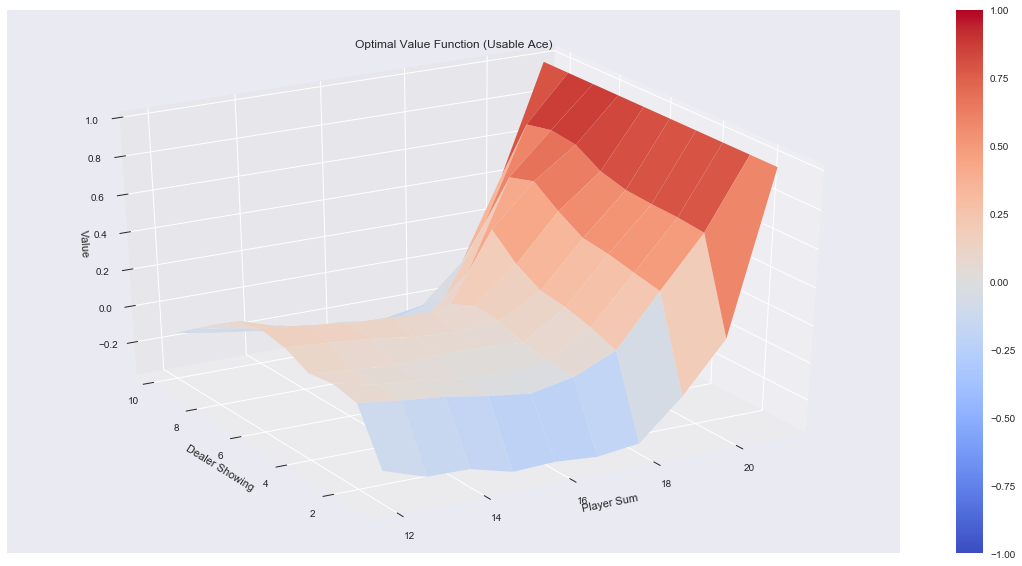

In [136]:
Q = On_Policy_Evaluation(episode_nums=5000000)

V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")